# Apply PSO on Matching Network Optimization
From separate code on PSO and Matching Network, it's time to merge these 2 to make an optimization for MN

In [1]:
import numpy as np
import matplotlib.pyplot as plt

----------------------------------------------------------
## I. Define Matching Network

Still, suppose I have a MN of 5 component like this:

*-------------L2-------------------C3---------------C1---------------*

     |          |             |             |
           
    Z_out      L1             C2             Z_load
           
     |          |             |             |
      
*---------------------------------------------------------------------*

and Z_load is not matched at 50Ohm, so with help from MN, I expect to get Z_out matched

Let's try to simplify the parallel or series type of a circuit

In [2]:
def parallel(Z1, Z2):
    return 1/(1/Z1 + 1/Z2)

def series(Z1, Z2): 
    return Z1 + Z2

Then, I assign type (R/L/C), connection orientation (ser/par), lowest and highest values of 5 components, respectively:

In [3]:
num_component = 5

component_type = ('C', 'C', 'C', 'L', 'L')
component_topology = ('ser', 'par','ser', 'par','ser')
range_C = (1e-12, 100e-12)
range_distance_C = range_C[1] - range_C[0]
range_L = (1e-9, 100e-9)
range_distance_L = range_L[1] - range_L[0]

And the function to calculate output impedance from Z load and MN

*note: for component type: 0 - C, 1 - L, 2 - R; for component placement: 0 - series, 1 - parallel*

In [4]:
def out_impedance(num_component, components, freq, Z_load):
    Z = np.zeros((num_component+1,),dtype = complex)
    Z_out = np.zeros((num_component+1,),dtype = complex)
    # calculate impedance of each component
    Z[0] = Z_load
    #print (Z[0],end = '   ')
    for i in range(num_component):
        if components[i][0] == 0: # C
            Z[i+1] = 1/(1j*2*np.pi*freq*components[i][2])
        elif components[i][0] == 1: # L
            Z[i+1] = 1j*2*np.pi*freq*components[i][2]
        else: # R
            Z[i+1] = components[i][2]
    # calculate result
    Z_out[0] = Z_load
    for i in range(num_component):
        if components[i][1] == 0: # series
            Z_out[i+1] = series(Z_out[i], Z[i+1])
        else:                     # parallel
            Z_out[i+1] = parallel(Z_out[i], Z[i+1])
        #print ('\n Zout', i+1,' :', Z_out[i+1])
    return Z_out[num_component]

---------------------------------------------
## II. Apply PSO
General parameters of PSO are defined here, meaning of them is *PSOsinc* notebook


In [5]:
w = 0.5
c1 = 2
c2 = 2
max_iter = 5000
freq = 1e+9
Z_load = 20
Z0 = 50

### First step
Define the Solution Space

Five bees, or better-5 particles, will be assigned to the task to look for the best position in their so-called Solution Space. This space is 5D, as each agent needs 5 variables to define its location, seem unrealistic hah? :v

In [6]:
agent_quantity = 5
space_dimention = 5
agent_bound = np.zeros([5,2])
for i in range(space_dimention):
    if component_type[i] == 'C':
        agent_bound[i] = range_C
    else:
        agent_bound[i] = range_L
agent_bound

array([[1.e-12, 1.e-10],
       [1.e-12, 1.e-10],
       [1.e-12, 1.e-10],
       [1.e-09, 1.e-07],
       [1.e-09, 1.e-07]])

### Second step
Define a fitness function. In this case, it's the S11 at given frequency

In [7]:
def fitness(agent):
    components = np.zeros([5,3])
    for i in range(agent_quantity):
        # Component type
        if component_type[i] == 'C':
            components[i][0] = 0 # C
        elif component_type[i] == 'L':
            components[i][0] = 1 # L
        else:
            components[i][0] = 1 # R
        # Component placement
        if component_topology[i] == 'ser':
            components[i][1] = 0
        else:
            components[i][1] = 1
        # Component value
        components[i][2] = agent[i]
        
    #print(components)
    Z_out = out_impedance(agent_quantity, components, freq, Z_load)
    fitness = np.abs((Z_out - Z0)/(Z_out + Z0))
    return 1 - fitness
# Check fitness function
fitness([10e-12, 20e-12, 30e-12, 40e-9, 50e-9])

0.0015327902737268806

### Third step 
Initialize Random Swam Location and Velocities

In [8]:
agent_location = np.zeros([agent_quantity, space_dimention])
for i in range(space_dimention):
    if component_type[i] == 'C':
        for j in range(agent_quantity):
            agent_location[j][i] = range_distance_C*np.random.rand()+range_C[0]
    elif component_type[i] == 'L':
        for j in range(agent_quantity):
            agent_location[j][i] = range_distance_L*np.random.rand()+range_L[0]

agent_location

array([[4.96293389e-11, 1.76073564e-11, 3.40669584e-11, 1.02754948e-08,
        7.84040588e-08],
       [4.81659338e-11, 1.11799064e-11, 5.05700548e-11, 1.49776859e-08,
        9.96291875e-08],
       [7.42082887e-12, 3.81902249e-11, 9.97317790e-11, 1.34162002e-08,
        5.79649041e-08],
       [9.99859552e-11, 2.17872271e-11, 1.56681115e-11, 3.19506003e-08,
        1.31235383e-08],
       [6.62021634e-11, 5.40871488e-11, 5.09300491e-12, 8.22727121e-08,
        3.72138792e-08]])

*pbest at first is also the first swam*

In [9]:
agent_pbest = agent_location

In [10]:
agent_velocity = np.zeros([agent_quantity, space_dimention])
for i in range(space_dimention):
    if component_type[i] == 'C':
        for j in range(agent_quantity):
            agent_velocity[j][i] = range_distance_C*np.random.rand()+range_C[0]
    elif component_type[i] == 'L':
        for j in range(agent_quantity):
            agent_velocity[j][i] = range_distance_L*np.random.rand()+range_L[0]

agent_velocity

array([[5.08768471e-11, 1.78275212e-12, 1.90808016e-11, 5.11290933e-08,
        8.75863169e-08],
       [1.10570196e-11, 3.99483247e-11, 2.63679265e-11, 7.52150166e-08,
        8.07848189e-08],
       [8.78176366e-11, 1.85496164e-11, 3.48674798e-11, 2.93512386e-08,
        6.86652086e-08],
       [2.54166250e-11, 4.33072052e-11, 9.05625999e-11, 6.06689753e-08,
        5.89340974e-08],
       [7.29165294e-11, 7.83502202e-11, 1.81187047e-11, 9.80042086e-09,
        2.83326531e-08]])

### Fourth step
Systematically Fly the Particles Through the Solution Space

a) Evaluate the Particles's Fitness, Compare to gbest, pbest

In [11]:
agent_fitness = np.zeros([agent_quantity,1])
pbest = np.zeros([agent_quantity,1])

for i in range(0,agent_quantity):
    agent_fitness[i] = fitness(agent_location[i])
    if agent_fitness[i] > pbest[i]:
            pbest[i] = agent_fitness[i]
            agent_pbest[i] = agent_location[i]
    
pbest

array([[0.00192224],
       [0.00199915],
       [0.00028609],
       [0.03885248],
       [0.00111693]])

In [12]:
gbest = np.zeros(1)
gbest[0] = pbest.max()
gbest_position = pbest.argmax()
print('\n Global best', gbest[0])
print('\n Global best position', gbest_position)
print('\n Agent at best position', agent_pbest[gbest_position])


 Global best 0.038852484624601336

 Global best position 3

 Agent at best position [9.99859552e-11 2.17872271e-11 1.56681115e-11 3.19506003e-08
 1.31235383e-08]


b) Update the Particle's velocity 

In [13]:
for i in range(agent_quantity):
    agent_velocity[i] = w*agent_velocity[i] + c1*np.random.rand()*(agent_pbest[i] - agent_location[i]) + c2*np.random.rand()*(agent_pbest[gbest_position]- agent_location[i])
    
agent_velocity

array([[ 4.81168408e-11,  2.77380698e-12,  1.25436497e-12,
         3.53260661e-08,  1.43936675e-08],
       [ 9.86982598e-11,  3.90455828e-11, -4.95679469e-11,
         6.81239409e-08, -1.15140326e-07],
       [ 7.92068149e-11,  3.01982875e-12, -1.46223828e-11,
         2.17433695e-08,  1.72331800e-08],
       [ 1.27083125e-11,  2.16536026e-11,  4.52812999e-11,
         3.03344876e-08,  2.94670487e-08],
       [ 9.33397272e-11, -1.52079739e-11,  2.68645630e-11,
        -7.98266706e-08, -2.63943609e-08]])

c) Move the particle

In [14]:
agent_location = agent_location + agent_velocity
for i in range(agent_quantity):
    for j in range(space_dimention):
        if agent_location[i][j] > agent_bound[j][1]:
            agent_location[i][j] = 2*agent_bound[j][1] - agent_location[i][j]
        if agent_location[i][j] < agent_bound[j][0]:
            agent_location[i][j] = 2*agent_bound[j][0] - agent_location[i][j]
        
agent_location

array([[9.77461798e-11, 2.03811634e-11, 3.53213234e-11, 4.56015609e-08,
        9.27977263e-08],
       [5.31358064e-11, 5.02254891e-11, 1.00210789e-12, 8.31016268e-08,
        1.75111389e-08],
       [8.66276438e-11, 4.12100536e-11, 8.51093962e-11, 3.51595697e-08,
        7.51980840e-08],
       [8.73057323e-11, 4.34408296e-11, 6.09494115e-11, 6.22850879e-08,
        4.25905871e-08],
       [4.04581094e-11, 3.88791749e-11, 3.19575679e-11, 2.44604145e-09,
        1.08195183e-08]])

### Fifth step
Repeat everything in Step 4 untill iteration being out of range 

In [15]:
for k in range(max_iter):
    if gbest[k] > 0.99:
        print('Converged!!! Hura!!')
        break
    # Step 4a
    for i in range(agent_quantity):
        agent_fitness[i] = fitness(agent_location[i])
        if agent_fitness[i] > pbest[i]:
            pbest[i] = agent_fitness[i]
            agent_pbest[i] = agent_location[i]
    
    gbest = np.append(gbest, pbest.max())
    gbest_position = pbest.argmax()
    # Step 4b
    for i in range(agent_quantity):
        agent_velocity[i] = w*agent_velocity[i] + c1*np.random.rand()*(agent_pbest[i] - agent_location[i]) + c2*np.random.rand()*(agent_pbest[gbest_position]- agent_location[i])
    
    # Step 4c
    agent_location = agent_location + agent_velocity
    for i in range(agent_quantity):
        for j in range(space_dimention):
            if agent_location[i][j] > agent_bound[j][1]:
                agent_location[i][j] = 2*agent_bound[j][1] - agent_location[i][j]
            if agent_location[i][j] < agent_bound[j][0]:
                agent_location[i][j] = 2*agent_bound[j][0] - agent_location[i][j]
    #print('Iteration: ', k)
    #print('Gbest in this iteration: ', gbest)
                
print('\n Agent at best position', agent_pbest[gbest_position])            
print('Gbest value is ', gbest[k])

Converged!!! Hura!!

 Agent at best position [7.08277074e-11 1.15238650e-11 1.67701056e-11 3.94439777e-09
 4.43151191e-09]
Gbest value is  0.9974814684270243


-----------------------------------------------------------
# III. Result
Final result is shown here, good or not, it's already taken a lot of time. Let's try to draw a graph to see the convergence progress

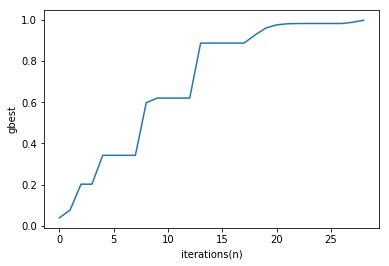

In [16]:
iterate = np.arange(k+1)
plt.plot(iterate,gbest)
plt.xlabel('iterations(n)')
plt.ylabel('gbest')
plt.show()

In [17]:
agent_gbest = agent_pbest[gbest_position]
components = np.zeros([5,3])
for i in range(agent_quantity):
    # Component type
    if component_type[i] == 'C':
        components[i][0] = 0 # C
    elif component_type[i] == 'L':
        components[i][0] = 1 # L
    else:
        components[i][0] = 1 # R
    # Component placement
    if component_topology[i] == 'ser':
        components[i][1] = 0
    else:
        components[i][1] = 1
    # Component value
    components[i][2] = agent_gbest[i]
        
#print(components)
Z_out = out_impedance(agent_quantity, components, freq, Z_load)
print('Z output is ', Z_out)

Z output is  (49.95342597976987-0.247390767068552j)
